# Examining Retweets
19DEC2020<br>
Richard Kuzma and Iain Cruickshank


- Power law to RTs
- No 'virality' (100+ RTs) to any particular article content group
- No 'virality' (100+ RTs) to any particular article group

### Imports

In [45]:
import pandas as pd, numpy as np, pickle, time, re


from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import math

In [2]:
from sklearn.decomposition import PCA, KernelPCA

import seaborn as sns
from sklearn.metrics import classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import SilhouetteVisualizer




In [3]:
src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/'
save_name = 'pca_2_dim_of_10k_articles_25k_words_with_metadata.pkl'

with open(src_path + save_name, 'rb') as f:
    df = pickle.load(f)

In [4]:
df.head()

,id_str,principal component 1,principal component 2,group,month,retweet_count,favorite_count,Hash words
0,1.220739e+18,-0.095522,-0.040655,4,2020-01,3.0,8.0,#vaccine #vaccine #coronavirus. #wuhan #davos
1,1.220751e+18,-0.098015,-0.113467,4,2020-01,0.0,4.0,No hashtags
2,1.220751e+18,-0.117528,-0.112577,4,2020-01,2.0,2.0,#fightflu:
3,1.220748e+18,-0.113455,-0.000196,1,2020-01,0.0,1.0,#flushotfriday
4,1.220745e+18,-0.113876,-0.098791,4,2020-01,2.0,2.0,#cancer: #hepatitisc #hpv


# Examine Retweets

# total tweets: 10776
# tweets with 0 RTs: 6628
# tweets with >0 RTs: 4148
# tweets with >10 RTs: 1157
# tweets with >25 RTs: 695
# tweets with >50 RTs: 419
# tweets with >100 RTs: 202
# tweets with >250 RTs: 80
# tweets with >500 RTs: 29
# tweets with >1000 RTs: 9
# tweets with >1500 RTs: 8
# tweets with >2000 RTs: 7
# tweets with >2500 RTs: 5
# tweets with >3000 RTs: 2
# tweets with >4000 RTs: 1


<AxesSubplot:>

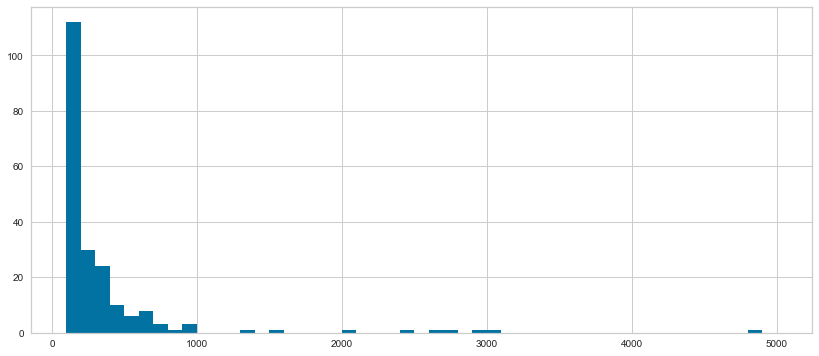

In [93]:
RT = df.copy(deep=True)
print('# total tweets: {}'.format(RT.shape[0]))
print('# tweets with 0 RTs: {}'.format(RT[RT['retweet_count'] ==0 ].shape[0]))

thresholds = [0, 10, 25, 50, 100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000]
tweets_by_RT = []
for thresh in thresholds:
    num_tweets = RT[RT['retweet_count'] > thresh].shape[0]
    print('# tweets with >{} RTs: {}'.format(thresh, num_tweets))
    tweets_by_RT.append(num_tweets)

plt.figure(figsize=(14,6))
RT['retweet_count'].hist(bins=range(99, 5000, 100))


In [92]:
ten_plus_rts = RT[RT['retweet_count'] >= 10]
ten_plus_rts.shape

(1213, 8)

In [83]:
print('dubious tweets with >= 10 RTs: {}'.format(ten_plus_rts[ten_plus_rts['group'] == 0].shape[0]))
print('govt tweets with >= 10 RTs: {}'.format(ten_plus_rts[ten_plus_rts['group'] == 1].shape[0]))
print('news tweets with >= 10 RTs: {}'.format(ten_plus_rts[ten_plus_rts['group'] == 2].shape[0]))
print('science tweets with >= 10 RTs: {}'.format(ten_plus_rts[ten_plus_rts['group'] == 4].shape[0]))

dubious tweets with >= 10 RTs: 362
govt tweets with >= 10 RTs: 31
news tweets with >= 10 RTs: 587
science tweets with >= 10 RTs: 233


RT bins:
- 0-24
- 25-99
- 100-249
- 249-499
- 500+

In [95]:
RT['retweet_count'][0]

3.0

In [169]:
def bin_retweets(num_rts):
    if num_rts == 0:
        return 0
    elif num_rts < 25:
        return 1
    elif num_rts < 100:
        return 2
    elif num_rts < 250:
        return 3
    elif num_rts < 500:
        return 4
    else:
        return 5


RT['retweet_bin'] = RT['retweet_count'].apply(lambda x: bin_retweets(x))
RT.head()

,id_str,principal component 1,principal component 2,group,month,retweet_count,favorite_count,Hash words,retweet_bin
0,1.220739e+18,-0.095522,-0.040655,4,2020-01,3.0,8.0,#vaccine #vaccine #coronavirus. #wuhan #davos,1
1,1.220751e+18,-0.098015,-0.113467,4,2020-01,0.0,4.0,No hashtags,0
2,1.220751e+18,-0.117528,-0.112577,4,2020-01,2.0,2.0,#fightflu:,1
3,1.220748e+18,-0.113455,-0.000196,1,2020-01,0.0,1.0,#flushotfriday,0
4,1.220745e+18,-0.113876,-0.098791,4,2020-01,2.0,2.0,#cancer: #hepatitisc #hpv,1


In [170]:

RT_bin_colors = {'0': 'white', 
              '1':'gray', 
              '2':'tab:olive', 
              '3':'lightblue', 
              '4':'green', 
              '5':'red', 
             }
domain_color = {'0': 'red', 
                 '1':'blue', 
                 '2':'yellow', 
                 '3':'gray', 
                 '4':'green'
             }


### Plot All Articles for reference

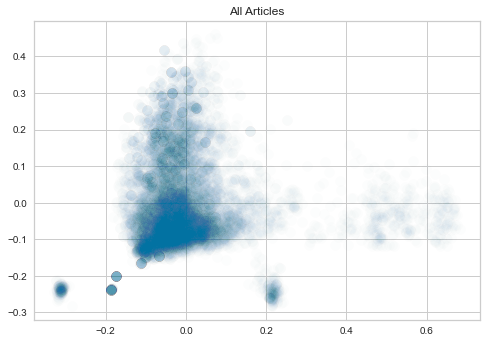

In [111]:
plt.title('All Articles')
plt.scatter(RT.iloc[:, 1], RT.iloc[:, 2], 
                c = 'b',
                alpha=.01,
                s = 100
               )

### Plot High RT articles

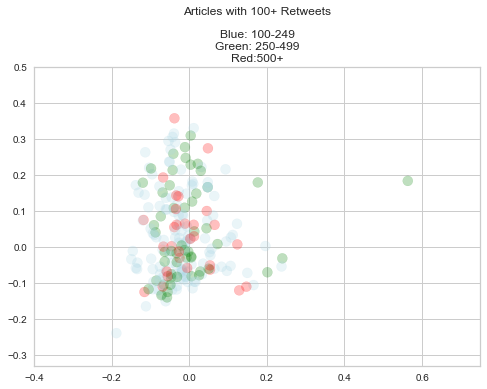

In [164]:
# blue is 100 - 249 RTs
# green is 250 - 500 RTs
# red is > 500 RTs

plt.title('Articles with 100+ Retweets\n\nBlue: 100-249\nGreen: 250-499\nRed:500+')
plt.xlim(-.4, .75)
plt.ylim(-.33, .5)
plt.scatter(RT[RT['retweet_bin'] > 2].iloc[:, 1], RT[RT['retweet_bin'] > 2].iloc[:, 2], 
                c = [RT_bin_colors[str(i)] for i in RT[RT['retweet_bin'] > 2]['retweet_bin']],
                alpha=.25,
                s = 100
               )

Most high (>=100) retweeted articles are News or Dubious

In [166]:
RT[RT['retweet_bin'] > 2]['group'].value_counts()

2    98
0    76
4    30
1     2
Name: group, dtype: int64

But high RT articles are still a small percentage of News or Dubiuous tweets

In [156]:
num_dubious = RT[RT['group'] == 0].shape[0]
num_news = RT[RT['group'] == 2].shape[0]
print('Num News Articles: {}'.format(num_news))
print('Num Dubious Articles: {}'.format(num_dubious))
dubious_100_plus_RTs = (RT[RT['retweet_bin'] > 2]['group'].value_counts()[0])
news_100_plus_RTs = (RT[RT['retweet_bin'] > 2]['group'].value_counts()[2])
print('\nDubious articles with 100+ retweets: {}. {}% of total dubious articles'.format(dubious_100_plus_RTs, round(100*dubious_100_plus_RTs/num_dubious, 2)))
print('News articles with 100+ retweets: {}. {}% of total dubious articles'.format(news_100_plus_RTs, round(100*news_100_plus_RTs/num_news,2)))



Num News Articles: 5819
Num Dubious Articles: 2348

Dubious articles with 100+ retweets: 76. 3.24% of total dubious articles
News articles with 100+ retweets: 98. 1.68% of total dubious articles


### High RT Articles By Domain

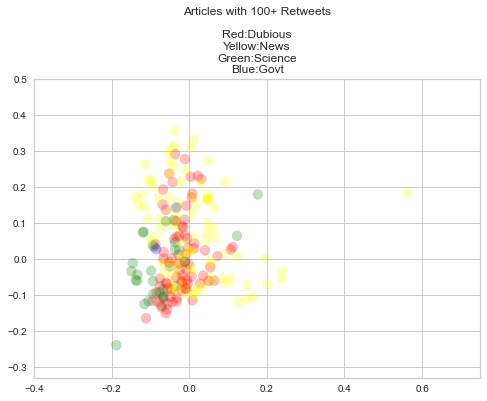

In [177]:
plt.title('Articles with 100+ Retweets\n\nRed:Dubious\nYellow:News\nGreen:Science\nBlue:Govt')
plt.xlim(-.4, .75)
plt.ylim(-.33, .5)

retweet_bin_above = 2

plt.scatter(RT[RT['retweet_bin'] > retweet_bin_above].iloc[:, 1], RT[RT['retweet_bin'] > retweet_bin_above].iloc[:, 2], 
                c = [domain_color[str(i)] for i in RT[RT['retweet_bin'] > retweet_bin_above]['group']],
                alpha=.25,
                s = 100
               )

In [ ]:
n_clusters = 7
km = KMeans(n_clusters=n_clusters, random_state=42).fit(feat_all)
preds = km.predict(feat_all)

print("Score for number of cluster(s) {}: {}".format(n_clusters,km.score(feat_all)))    

silhouette = silhouette_score(feat_all,preds)
print("Silhouette score for number of cluster(s) {}: {}".format(n_clusters,silhouette))

plt.scatter(feat_all[0], feat_all[1], 
                c = [color_dict[str(i)] for i in preds],
                alpha=.05,
                s = 100
               )

plt.title('2-Dim PCA Scatter, n_clusters = 7')
plt.show()

# Add cluster labels as labels

In [ ]:
preds_7 = pd.DataFrame(data=preds, columns = ['preds_7'])
df = pd.concat([df, preds_7], axis = 1)
df.head()